## Import packages:

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
import gensim
import re
import unicodedata
import datetime
import collections
import random
import time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import pylab
from gensim.models.phrases import Phraser
from gensim.models import Phrases
from sklearn.manifold import TSNE
import treetaggerwrapper
import string
import os
import platform
treetaggerPath = str(os.getcwd()) + "/treetagger/" + str(platform.system()) + "/"

In [2]:
treetaggerPath

'/home/francesco/workspace/git/TISProject/NB_Presentazione/treetagger/Linux/'

## Load dataset:

In [3]:
train = pd.read_csv("../Dataset/cleaned_data.csv", delimiter="\t")

In [4]:
print(train.shape)
train.head()

(9283, 2)


,Unnamed: 0,body
0,FM20160429032ACC9MUHD,acea essere pronto giocare partita banda ultra...
1,FM20160501023ACLAzwID,unico certezza momento essere prossimo tappa s...
2,FM20160503035ACaNSzJD,potere aspettare mese luglio formalizzazione p...
3,FM20160503035ACDx00JD,fondo chiuso aiutare piccolo medio impresa ita...
4,FM20160428033ACi2kvGD,volto provocazione sortire effetto sperare ext...


In [5]:
train["body"] = train["body"].apply(lambda x:x.split(' '))

In [6]:
corp = list(train["body"])

## Word2Vec model:

In [7]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)
# Initialize and train the model (this will take some time)
from gensim.models import word2vec

In [8]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 20   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 20          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [9]:
print("Training model...")
model = word2vec.Word2Vec(sentences=corp, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, sorted_vocab=1)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
#model.init_sims(replace=True)


# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

2017-05-22 19:24:24,492 : INFO : collecting all words and their counts
2017-05-22 19:24:24,493 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Training model...


2017-05-22 19:24:25,098 : INFO : collected 34833 word types from a corpus of 1274549 raw words and 9283 sentences
2017-05-22 19:24:25,099 : INFO : Loading a fresh vocabulary
2017-05-22 19:24:25,155 : INFO : min_count=20 retains 5608 unique words (16% of original 34833, drops 29225)
2017-05-22 19:24:25,156 : INFO : min_count=20 leaves 1173726 word corpus (92% of original 1274549, drops 100823)
2017-05-22 19:24:25,186 : INFO : deleting the raw counts dictionary of 34833 items
2017-05-22 19:24:25,189 : INFO : sample=0.001 downsamples 32 most-common words
2017-05-22 19:24:25,190 : INFO : downsampling leaves estimated 1089728 word corpus (92.8% of prior 1173726)
2017-05-22 19:24:25,191 : INFO : estimated required memory for 5608 words and 300 dimensions: 16263200 bytes
2017-05-22 19:24:25,219 : INFO : resetting layer weights
2017-05-22 19:24:25,399 : INFO : training model with 4 workers on 5608 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=20
2017-05-22 19:24:2

In [10]:
model.most_similar("quotazione")

2017-05-22 19:26:16,590 : INFO : precomputing L2-norms of word weight vectors


[('borsa', 0.9192878603935242),
 ('mta', 0.8376414775848389),
 ('ipo', 0.8232322931289673),
 ('essere_quotare', 0.7730789184570312),
 ('listino', 0.7660068869590759),
 ('quotare', 0.7635006308555603),
 ('star', 0.749306321144104),
 ('aim', 0.7476506233215332),
 ('sbarco', 0.7222742438316345),
 ('matricola', 0.7111003398895264)]

In [11]:
model.most_similar("3")

[('4', 0.9296406507492065),
 ('2', 0.9208474159240723),
 ('5', 0.8889598250389099),
 ('1', 0.8606124520301819),
 ('7', 0.8413089513778687),
 ('6', 0.7879739999771118),
 ('8', 0.778730034828186),
 ('10', 0.7547396421432495),
 ('9', 0.6955190896987915),
 ('15', 0.665380597114563)]

In [12]:
model.most_similar("potere")

[('dovere', 0.8181290626525879),
 ('possibilità', 0.7790635228157043),
 ('escludere', 0.7641160488128662),
 ('magari', 0.7627406716346741),
 ('quindi', 0.7558209896087646),
 ('sufficiente', 0.7555112838745117),
 ('senza', 0.7545698881149292),
 ('perchè', 0.7536015510559082),
 ('dipendere', 0.7508028745651245),
 ('dunque', 0.7500941753387451)]

In [13]:
model.most_similar("radiocor")

[('plus', 0.9474889636039734),
 ('sole24ore', 0.8701058030128479),
 ('dalsole24ore', 0.8234608173370361),
 ('indiscrezione', 0.7850154638290405),
 ('intervista', 0.7701559066772461),
 ('stampa', 0.7632895112037659),
 ('ufficialmente', 0.7394756078720093),
 ('riunire', 0.7148219347000122),
 ('domani', 0.7114574313163757),
 ('agenda', 0.7104169130325317)]

In [14]:
model.wv.syn0.shape

(5608, 300)

In [15]:
x = {}
for word, vocab_obj in model.wv.vocab.items():
    #print('--------------------------')
    #print(word)
    #print(vocab_obj.count)
    x[word] = vocab_obj.count

In [16]:
import operator
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse= True)
print(sorted_x)

[('avere', 30935), ('milione', 19728), ('essere', 19288), ('euro', 9220), ('gruppo', 9210), ('anno', 7715), ('primo', 6242), ('nuovo', 5737), ('mercato', 5561), ('miliardo', 5179), ('fare', 4845), ('essere_stare', 4515), ('potere', 4439), ('azione', 4422), ('stare', 4313), ('2015', 4255), ('netto', 4184), ('crescita', 4181), ('operazione', 4008), ('società', 3953), ('altro', 3930), ('circa', 3855), ('capitale', 3833), ('pari', 3574), ('parte', 3557), ('mese', 3498), ('italia', 3423), ('fine', 3323), ('2014', 3280), ('1', 3272), ('finanziario', 3208), ('due', 3139), ('ricavo', 3062), ('risultato', 2989), ('prevedere', 2913), ('piano', 2884), ('secondo', 2806), ('dovere', 2805), ('italiano', 2789), ('rispetto', 2777), ('scorso', 2771), ('settore', 2760), ('proprio', 2697), ('grande', 2621), ('investimento', 2618), ('quota', 2591), ('oltre', 2577), ('azienda', 2566), ('ieri', 2564), ('vendita', 2507), ('prezzo', 2496), ('presidente', 2471), ('utile', 2463), ('stesso', 2460), ('aumento', 2

In [17]:
reverse_dictionary = {}
for idx,h in enumerate(sorted_x):
    reverse_dictionary[idx] = h[0]
    
reverse_dictionary

{0: 'avere',
 1: 'milione',
 2: 'essere',
 3: 'euro',
 4: 'gruppo',
 5: 'anno',
 6: 'primo',
 7: 'nuovo',
 8: 'mercato',
 9: 'miliardo',
 10: 'fare',
 11: 'essere_stare',
 12: 'potere',
 13: 'azione',
 14: 'stare',
 15: '2015',
 16: 'netto',
 17: 'crescita',
 18: 'operazione',
 19: 'società',
 20: 'altro',
 21: 'circa',
 22: 'capitale',
 23: 'pari',
 24: 'parte',
 25: 'mese',
 26: 'italia',
 27: 'fine',
 28: '2014',
 29: '1',
 30: 'finanziario',
 31: 'due',
 32: 'ricavo',
 33: 'risultato',
 34: 'prevedere',
 35: 'piano',
 36: 'secondo',
 37: 'dovere',
 38: 'italiano',
 39: 'rispetto',
 40: 'scorso',
 41: 'settore',
 42: 'proprio',
 43: 'grande',
 44: 'investimento',
 45: 'quota',
 46: 'oltre',
 47: 'azienda',
 48: 'ieri',
 49: 'vendita',
 50: 'prezzo',
 51: 'presidente',
 52: 'utile',
 53: 'stesso',
 54: 'aumento',
 55: 'nota',
 56: 'offerta',
 57: 'azionista',
 58: 'oggi',
 59: 'dopo',
 60: 'ultimo',
 61: '2',
 62: 'accordo',
 63: 'dire',
 64: 'cda',
 65: 'valore',
 66: 'banca',
 67: 

In [18]:
num_points= 400
tsne= TSNE(perplexity=30, n_components= 2, init='pca', n_iter= 5000)
two_d_embeddings= tsne.fit_transform(model.wv.syn0[1:num_points+1, :])

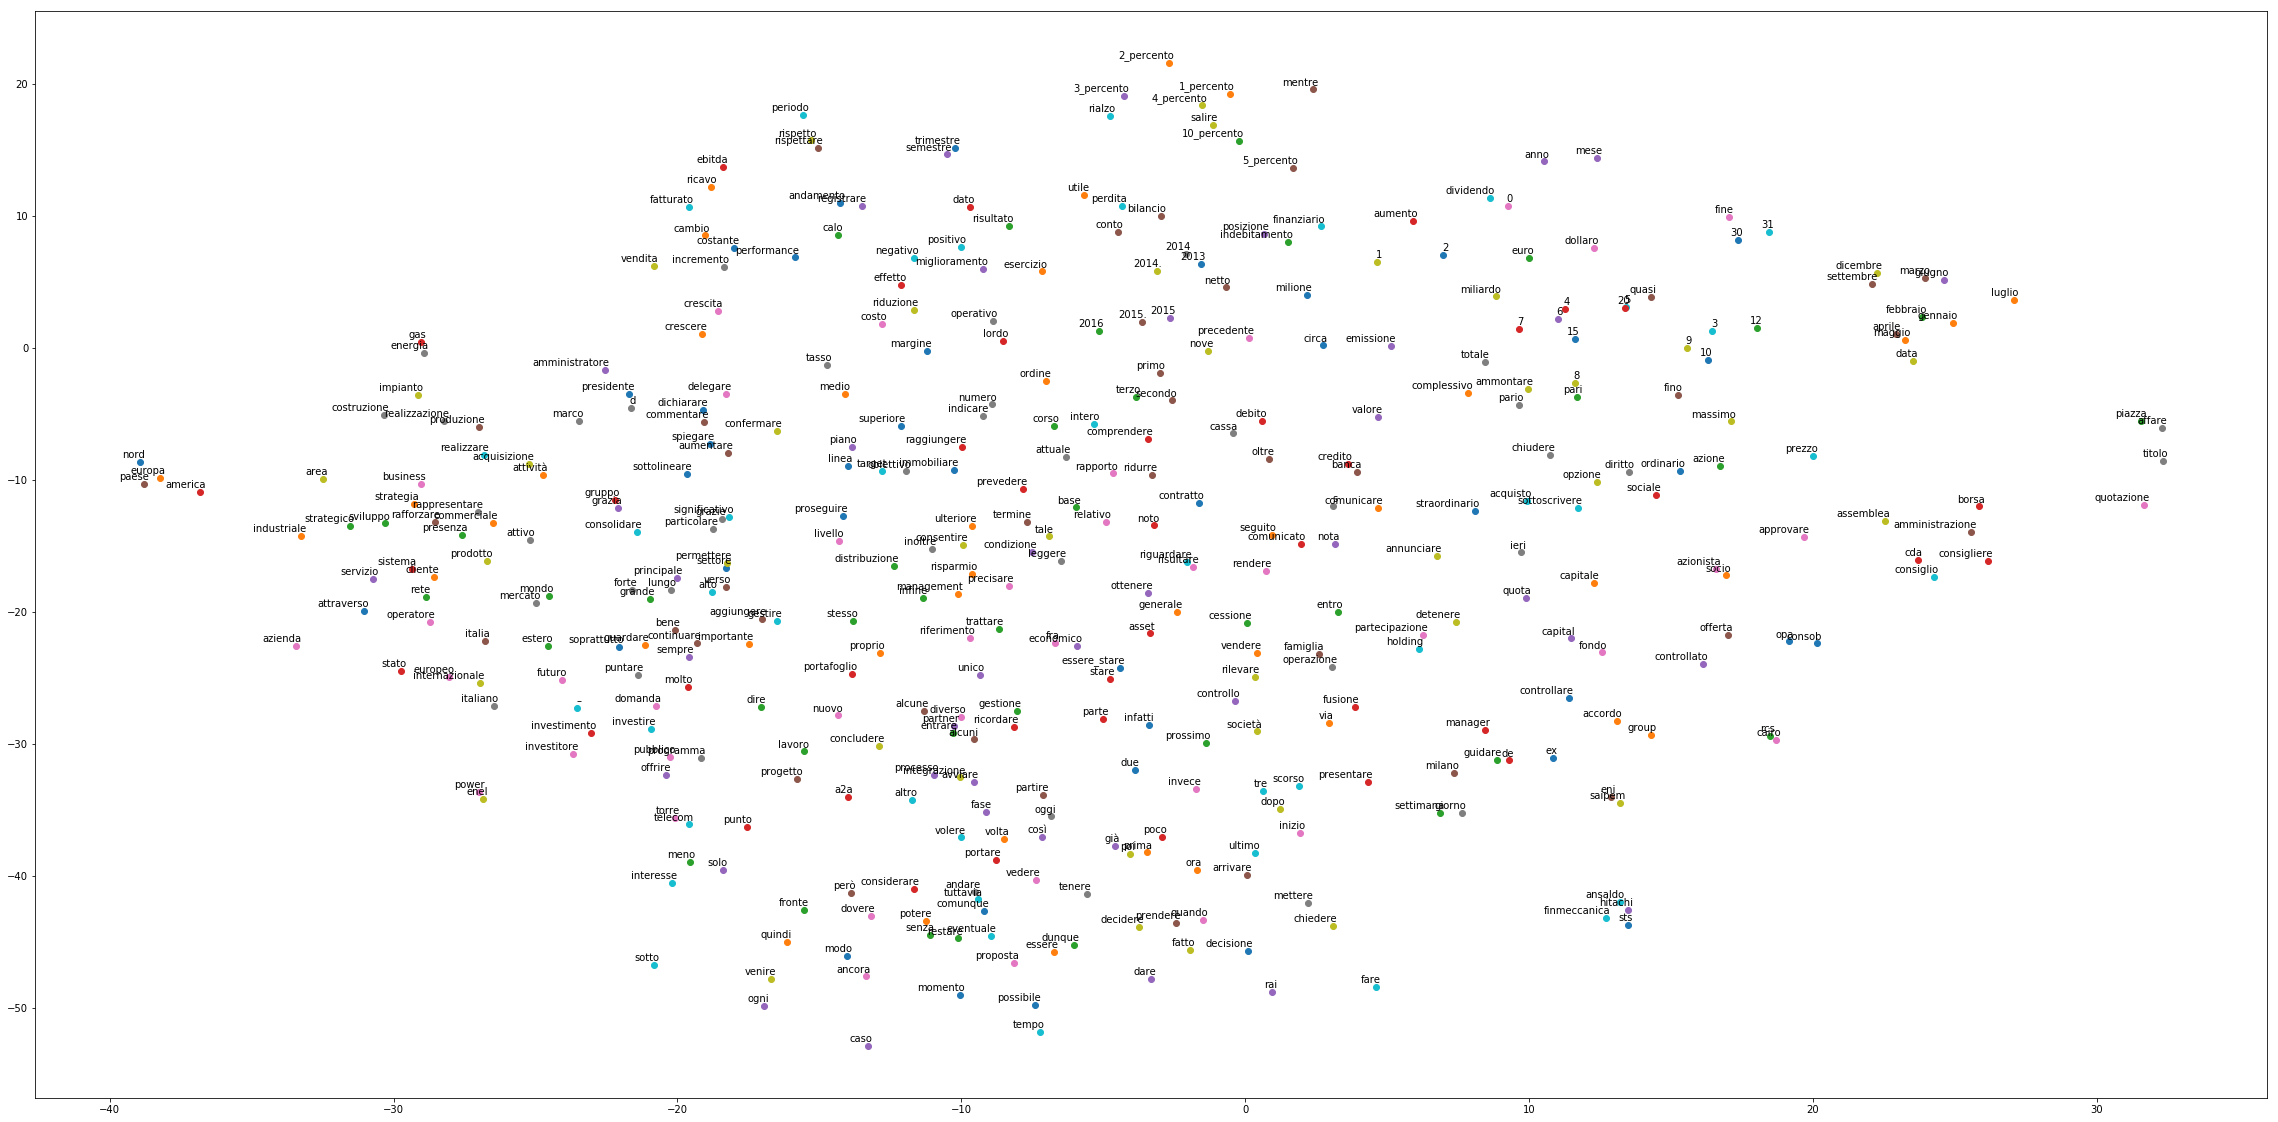

In [19]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(40,20)) # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)